In [36]:
# imports

from nemo.collections.tts.models import FlowtronModel
from nemo.collections.tts.models import WaveGlowModel
import IPython.display as ipd
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import torch
import os
from scipy.io.wavfile import write

In [34]:
# set parameters

# flowtron_path="/akshita/NeMo/tutorials/tts/nemo_experiments/FlowtronNGC/Flowtrone649.nemo"
# ext="nemo"
flowtron_path="/akshita/NeMo/tutorials/tts/nemo_experiments/FlowtronNGCattnpriors2_904/Flowtron--val_loss=-1.0509-epoch=207.ckpt"
outputdir="/akshita/NeMo/tutorials/tts/nemo_experiments/FlowtronNGCattnpriors2_904/"
ext="ckpt"
waveglow_pretrained_model="tts_waveglow"
text_input="It is well known that deep generative models have rich latent space"
speaker_id=0
sigma=0.5
sampling_rate=22050

In [25]:
# loading the models

if ext=="nemo":
    spec_gen_model = FlowtronModel.restore_from(restore_path=flowtron_path).eval().cuda()
else:
    spec_gen_model = FlowtronModel.load_from_checkpoint(checkpoint_path=flowtron_path).eval().cuda()
vocoder_model = WaveGlowModel.from_pretrained(waveglow_pretrained_model, strict=False).eval().cuda()

[NeMo W 2022-02-14 18:38:57 modelPT:135] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.FlowtronData
      manifest_filepath: /akshita/flowtron/filelists/ljs_audiopaths_text_sid_train_filelist.txt
      filter_length: 1024
      hop_length: 256
      win_length: 1024
      sampling_rate: 22050
      mel_fmin: 0.0
      mel_fmax: 8000.0
      n_frames_per_step: 1
      max_wav_value: 32768.0
      p_arpabet: 0.5
      cmudict_path: /akshita/flowtron/data/cmudict_dictionary
      text_cleaners:
      - flowtron_cleaners
      speaker_ids: null
      use_attn_prior: false
      attn_prior_threshold: 0.0
      prior_cache_path: /akshita/attention_prior_cache
      betab_scaling_factor: 1.0
      keep_ambiguous: false
      seed:
        model.seed: null
      randomize: true
    datalo

[NeMo I 2022-02-14 18:38:57 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.6.0/tts_waveglow/be8c69c04450b3da0ce5a38a8ef4014f/tts_waveglow.nemo.
[NeMo I 2022-02-14 18:38:57 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.6.0/tts_waveglow/be8c69c04450b3da0ce5a38a8ef4014f/tts_waveglow.nemo
[NeMo I 2022-02-14 18:38:57 common:729] Instantiating model from pre-trained checkpoint


[NeMo W 2022-02-14 18:39:01 modelPT:135] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_train.json
      max_duration: null
      min_duration: 0.1
      n_segments: 16000
      trim: false
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 12
      num_workers: 4
    
[NeMo W 2022-02-14 18:39:01 modelPT:142] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_val.json

[NeMo I 2022-02-14 18:39:01 features:264] PADDING: 16
[NeMo I 2022-02-14 18:39:01 features:281] STFT using torch
[NeMo I 2022-02-14 18:39:02 save_restore_connector:154] Model WaveGlowModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.6.0/tts_waveglow/be8c69c04450b3da0ce5a38a8ef4014f/tts_waveglow.nemo.


In [26]:
# run inference

with torch.no_grad():
    parsed = spec_gen_model.parse(text_input, speaker_id=speaker_id)
    spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed)
    print(spectrogram.size()) # debug
    audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram, sigma=sigma, denoise=True)

spectrogram = spectrogram.to('cpu').numpy()[0]
audio = audio.to('cpu').numpy()[0]
audio = audio / np.abs(audio).max()

Number of speakers : 1
Number of speakers : 1
torch.Size([1, 80, 400])


In [27]:
# listen to the audio

ipd.Audio(audio, rate=22050)

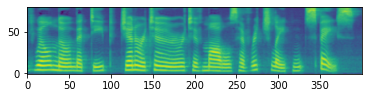

In [28]:
%matplotlib inline

# visualize the spectrogram

if spectrogram is not None:
    imshow(spectrogram, origin="lower")
    plt.show()

In [37]:
write(os.path.join(outputdir, 'sid{}_sigma{}.wav'.format(speaker_id, sigma)), sampling_rate, audio)